In [4]:
import os
import re
import time
import json
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import random
from torch_geometric.data import Data
import pybullet as p
import pybullet_data
import trimesh
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict, Counter
from utils.graph_env import set_objects
set_objects('set1')

from utils.graph_env import (
    OBJECTS,
    create_graph, plot_graph, cal_density,
    Indices, get_obj_label, get_obj_pos, get_obj_size,
    get_object_bellow,
    x_to_edge_index, get_node_poses
)

# Simulation

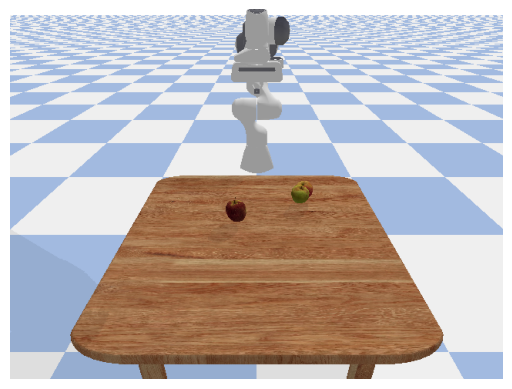

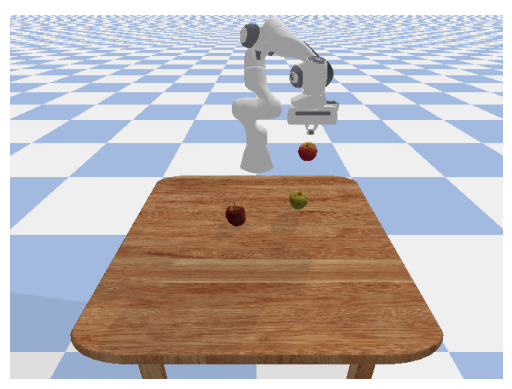

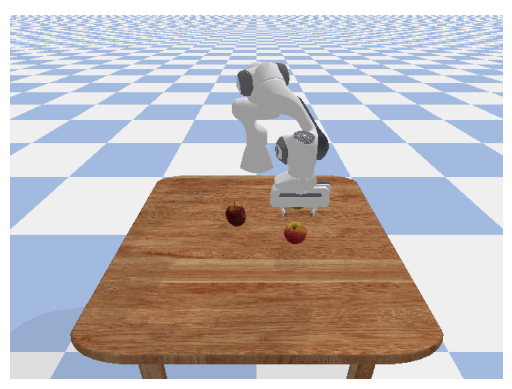

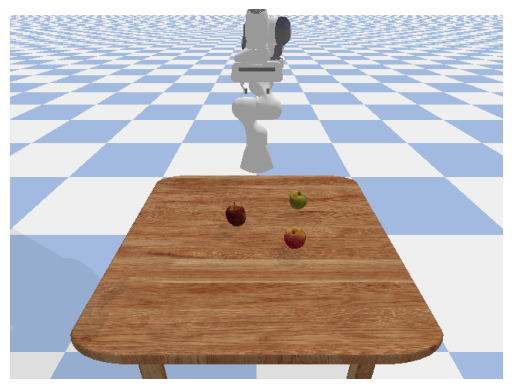

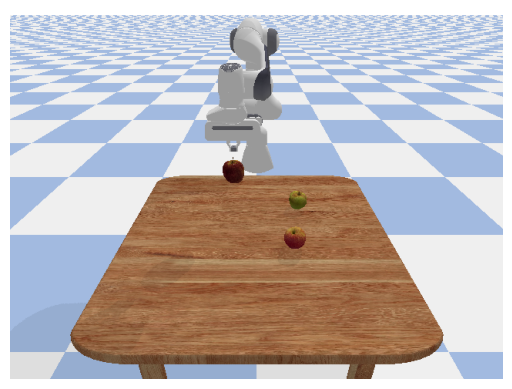

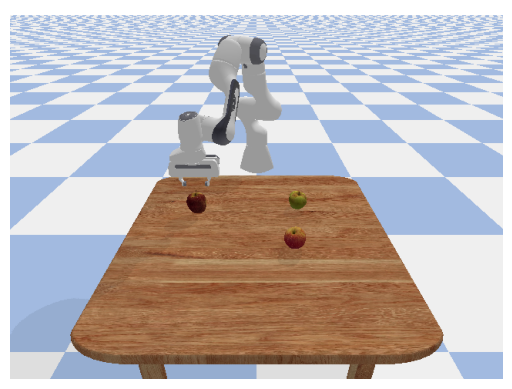

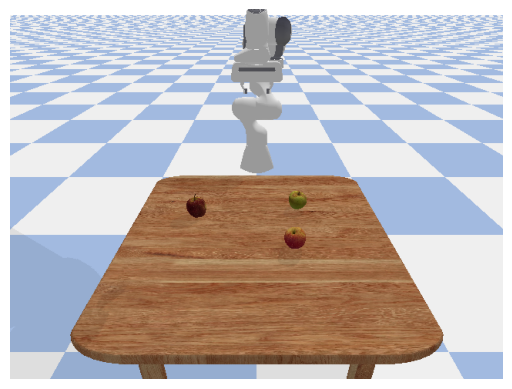

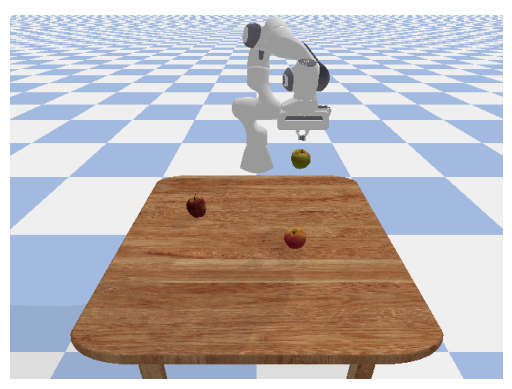

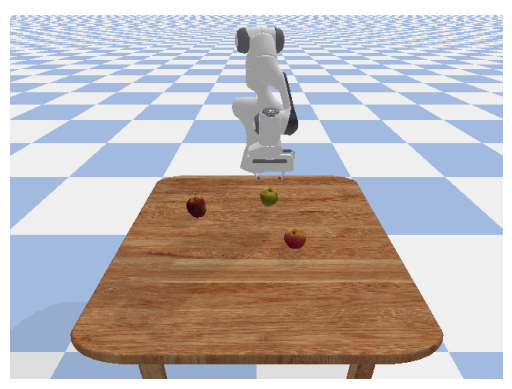

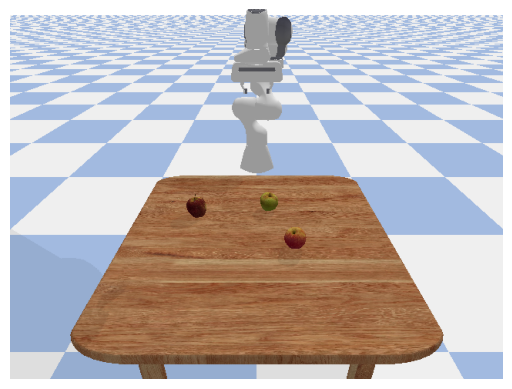

In [54]:
import roboticstoolbox as rtb
from utils.pybullet_utils import (
    Camera, PyBulletSim, load_object, load_table, get_size,
    Robot
)

def random_pos(x_range, y_range, z_range):
    return [
        random.uniform(*x_range),
        random.uniform(*y_range),
        random.uniform(*z_range)
    ]

def multiply_transforms(posA, ornA, posB, ornB):
    """Combine two transforms."""
    return p.multiplyTransforms(posA, ornA, posB, ornB)

def invert_transform(pos, orn):
    """Invert a transform."""
    return p.invertTransform(pos, orn)

def grasp_obj(robot, obj_id):
	robot.open_gripper()
	obj_pos, obj_orn = p.getBasePositionAndOrientation(obj_id)
	robot.go_to_pose([obj_pos[0], obj_pos[1], obj_pos[2]+0.3])
	robot.go_to_pose([obj_pos[0], obj_pos[1], obj_pos[2]+0.1])

	# Create the fixed constraint with relative pose
	ee_pos, ee_orn = robot.get_ee_pos()
	inv_ee_pos, inv_ee_orn = invert_transform(ee_pos, ee_orn)
	_, rel_orn = multiply_transforms(inv_ee_pos, inv_ee_orn, obj_pos, obj_orn)
	constraint_id = p.createConstraint(
		parentBodyUniqueId=robot_id,
		parentLinkIndex=11,
		childBodyUniqueId=obj_id,
		childLinkIndex=-1,
		jointType=p.JOINT_FIXED,
		jointAxis=[0, 0, 0],
		parentFramePosition=[0, 0, 0],
		childFramePosition=[0, 0, 0.1],
		childFrameOrientation=rel_orn
	)
	# robot.go_to_pose([obj_pos[0], obj_pos[1], obj_pos[2]])
	robot.close_gripper()
	
	robot.go_to_pose([obj_pos[0], obj_pos[1], obj_pos[2]+0.3])

	return constraint_id

def release_obj(robot, pos, constraint_id=None):
	robot.go_to_pose([pos[0], pos[1], pos[2]+0.3])
	robot.go_to_pose([pos[0], pos[1], pos[2]+0.1])
	robot.open_gripper()
	if constraint_id is not None:
		p.removeConstraint(constraint_id)

# sim = PyBulletSim(p.GUI)
sim = PyBulletSim(p.DIRECT)
table = load_table((100, 100))
z = get_size(table)[2]
x_range, y_range, z_range = [-0.3, 0.3], [-0.3, 0.3], [z+0.05, z+0.05]
cam = Camera(target_pos=[0.6, 0, 1.3], distance=0.5, yaw=90, pitch=-30, roll=0)

robot = Robot(p, "franka_panda/panda.urdf", rtb.models.Panda(), [-0.6, 0, z])
robot_id = robot.init('stationary', x_range, y_range)
init_pos = robot.get_ee_pos()[0]

apple1 = load_object('apple', random_pos(x_range, y_range, z_range), bodyType=1)[0]
apple2 = load_object('apple', random_pos(x_range, y_range, z_range), bodyType=2)[0]
apple3 = load_object('apple', random_pos(x_range, y_range, z_range), bodyType=3)[0]
cam.show_img(cam.capture_image())

constraint_id = grasp_obj(robot, apple1)
cam.show_img(cam.capture_image())
release_obj(robot, random_pos(x_range, y_range, z_range), constraint_id)
cam.show_img(cam.capture_image())
robot.go_to_pose(init_pos)
cam.show_img(cam.capture_image())

constraint_id = grasp_obj(robot, apple2)
cam.show_img(cam.capture_image())
release_obj(robot, random_pos(x_range, y_range, z_range), constraint_id)
cam.show_img(cam.capture_image())
robot.go_to_pose(init_pos)
cam.show_img(cam.capture_image())

constraint_id = grasp_obj(robot, apple3)
cam.show_img(cam.capture_image())
release_obj(robot, random_pos(x_range, y_range, z_range), constraint_id)
cam.show_img(cam.capture_image())
robot.go_to_pose(init_pos)
cam.show_img(cam.capture_image())

sim.close()